## Necessary Library Installations and Imports

Folktables - Python library that allows us to access US Census Datasets for different states that consists of mulltiple sensitive attributes. <br>
Polars - Python Data Manipulation and Handling library. Similar to Pandas

In [1]:
!pip install folktables


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
!pip install polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 57.0 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [34]:
import folktables
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from folktables import ACSDataSource, ACSIncome, ACSPublicCoverage, generate_categories

Downloading in the following code takes longer to run, hence, ran once and commented out.

In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
# ca_data = data_source.get_data(states=["CA","MA","TX", "NY", "GA"], download=True)

In [ ]:
# print(list(ca_data.head().columns))

['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'STATE', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR', 'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'INTP', 'JWMNP', 'JWRIP', 'JWTRNS', 'LANX', 'MAR', 'MARHD', 'MARHM', 'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPIK', 'MLPJ', 'NWAB', 'NWAV', 'NWLA', 'NWLK', 'NWRE', 'OIP', 'PAP', 'RELSHIPP', 'RETP', 'SCH', 'SCHG', 'SCHL', 'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKWN', 'WRK', 'YOEP', 'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR', 'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP', 'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC1P', 'RAC2P', 'RAC3P', 'RACAIAN', 'RACASN', 'RACBLK', 

In [4]:
# ca_features, ca_labels, _ = ACSPublicCoverage.df_to_pandas(ca_data)
# ca_features.to_csv('data/multi_state_features.csv', index=False)
# ca_labels.to_csv('data/multi_state_labels.csv', index=False)

# Commented because already ran once and saved the CSV files

In [5]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSPublicCoverage.features, definition_df=definition_df)

In [6]:
categories.keys()

dict_keys(['SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'ESR', 'ST', 'FER', 'RAC1P'])

In [7]:
features = pl.read_csv('data/multi_state_features.csv')
labels = pl.read_csv("data/multi_state_labels.csv")

In [8]:
features.shape,labels.shape

((364726, 19), (364726, 1))

In [9]:
features.describe()

statistic,AGEP,SCHL,MAR,SEX,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,PINCP,ESR,ST,FER,RAC1P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",35.933569,16.554655,3.346452,1.565156,1.865258,0.300036,1.89032,1.325938,3.658231,1.76107,1.239635,1.980813,1.9744,1.931077,9577.727653,3.353663,24.817581,0.80549,2.630556
"""std""",15.550484,4.126389,1.864167,0.495737,0.341449,1.217979,1.550974,0.731327,1.067738,1.129982,0.426861,0.137182,0.157939,0.253323,9969.563992,2.455723,17.82939,0.970503,2.692612
"""min""",15.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-8300.0,0.0,6.0,0.0,1.0
"""25%""",21.0,15.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,6.0,0.0,1.0
"""50%""",33.0,17.0,5.0,2.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,6600.0,3.0,25.0,0.0,1.0
"""75%""",50.0,19.0,5.0,2.0,2.0,0.0,3.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,18000.0,6.0,48.0,2.0,2.0
"""max""",64.0,24.0,5.0,2.0,2.0,8.0,5.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,30000.0,6.0,48.0,2.0,9.0


In [76]:
column_details = {}
for col in features.columns:
    print(col,"---",definition_df[definition_df[1]==col].values[0][4])
    d  = {}
    d['Definition'] = definition_df[definition_df[1]==col].values[0][4]
    d['Possible Values'] = [col[6] for col in (definition_df[definition_df[1]==col].values.tolist()[1:])]
    column_details[col]=d    


AGEP --- Age
SCHL --- Educational attainment
MAR --- Marital status
SEX --- Sex
DIS --- Disability recode
ESP --- Employment status of parents
CIT --- Citizenship status
MIG --- Mobility status (lived here 1 year ago)
MIL --- Military service
ANC --- Ancestry recode
NATIVITY --- Nativity
DEAR --- Hearing difficulty
DEYE --- Vision difficulty
DREM --- Cognitive difficulty
PINCP --- Total person's income (signed, use ADJINC to adjust to constant dollars)
ESR --- Employment status recode
ST --- State Code based on 2010 Census definitions
FER --- Gave birth to child within the past 12 months
RAC1P --- Recoded detailed race code


In [77]:
column_details['RAC1P']

{'Definition': 'Recoded detailed race code',
 'Possible Values': ['White alone',
  'Black or African American alone',
  'American Indian alone',
  'Alaska Native alone',
  'American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races',
  'Asian alone',
  'Native Hawaiian and Other Pacific Islander alone',
  'Some Other Race alone',
  'Two or More Races']}

In [85]:
import matplotlib.colors as mcolors
colors = np.random.choice(list(mcolors.CSS4_COLORS.keys()),size=19)
colors

array(['lightslategrey', 'plum', 'mediumslateblue', 'lightslategray',
       'darkcyan', 'tomato', 'antiquewhite', 'lightsteelblue', 'navy',
       'darkturquoise', 'honeydew', 'lightgrey', 'mediumorchid',
       'seagreen', 'mediumspringgreen', 'cyan', 'mistyrose',
       'darkturquoise', 'darksalmon'], dtype='<U20')

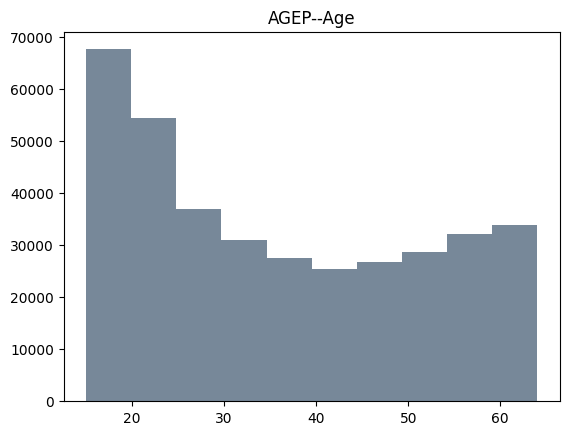

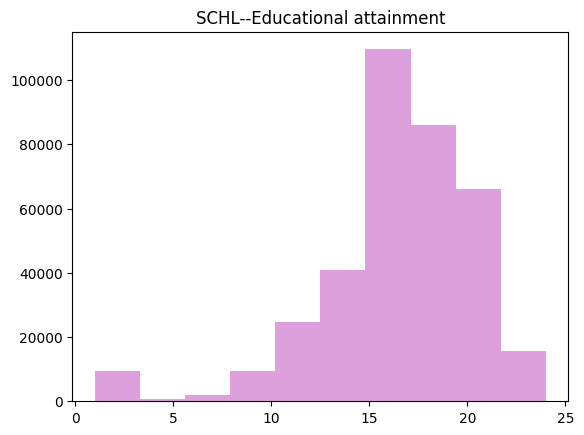

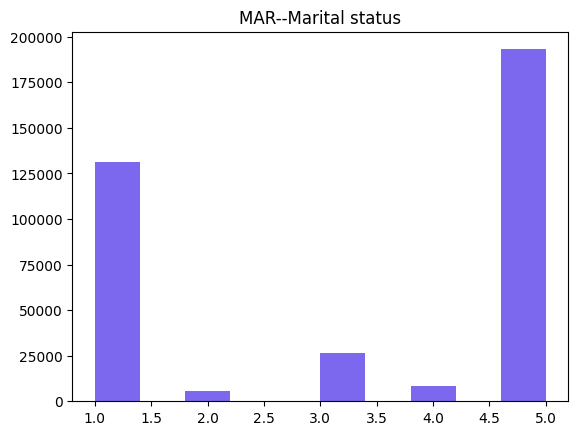

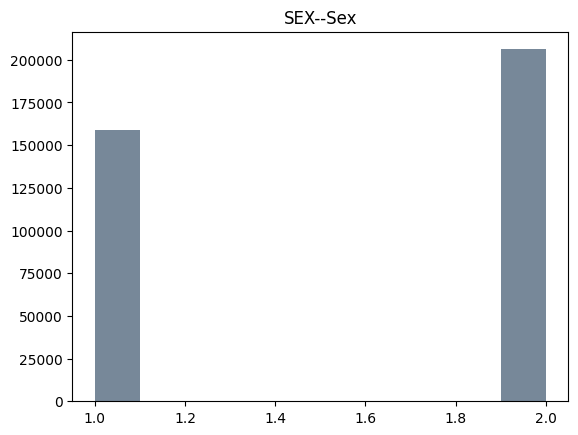

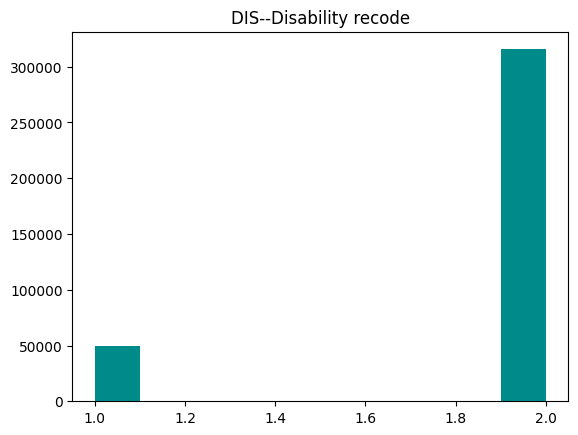

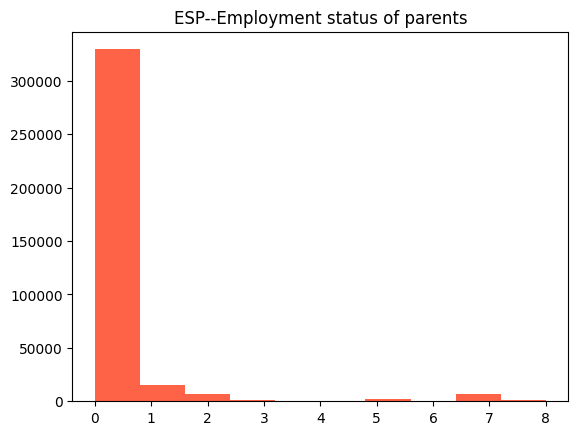

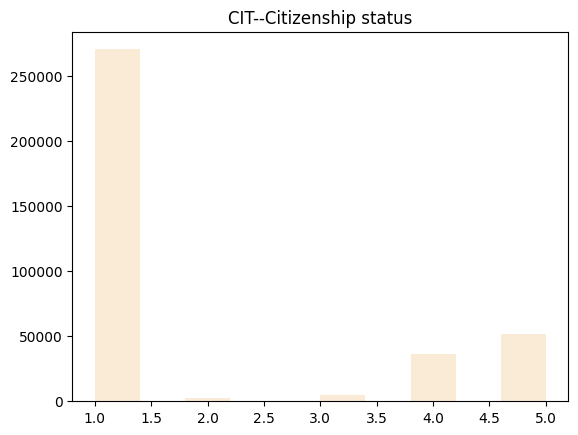

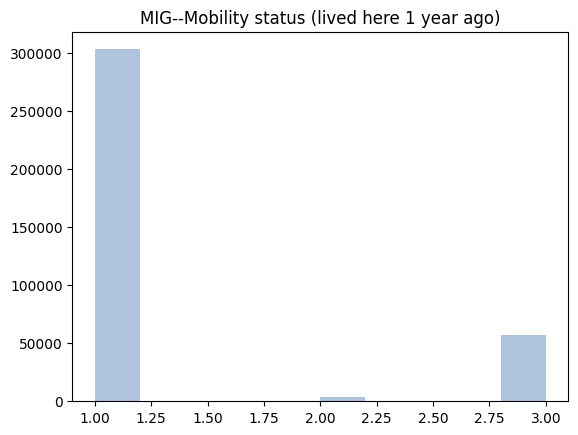

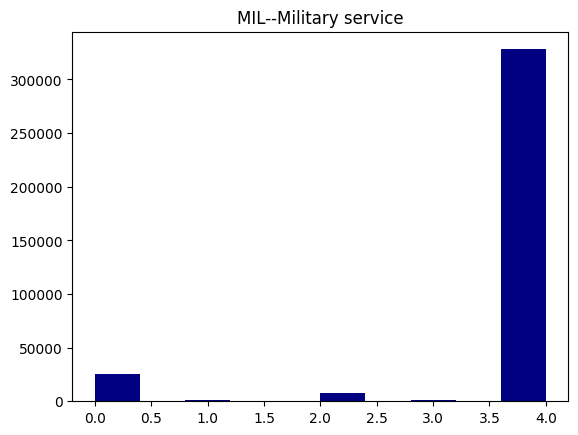

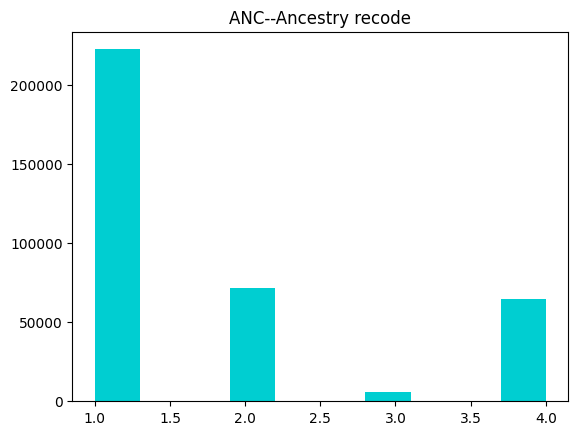

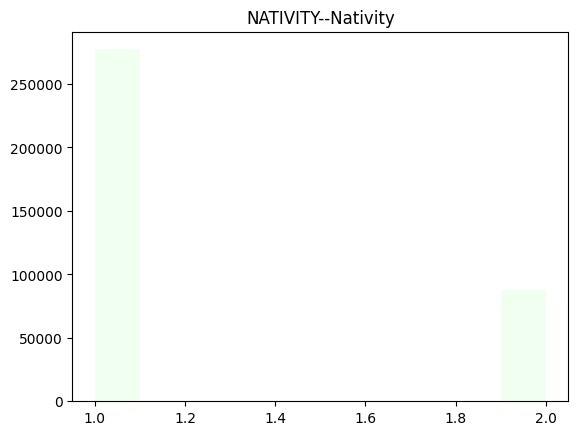

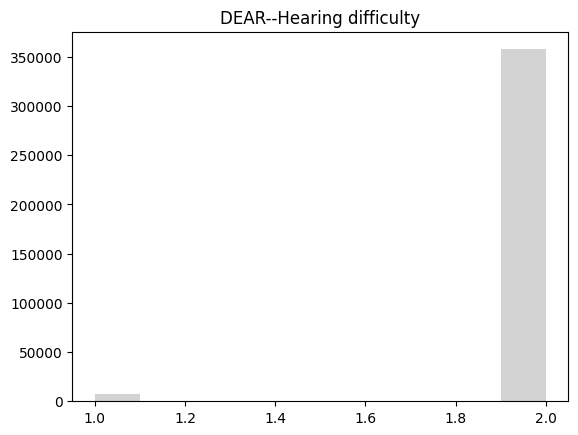

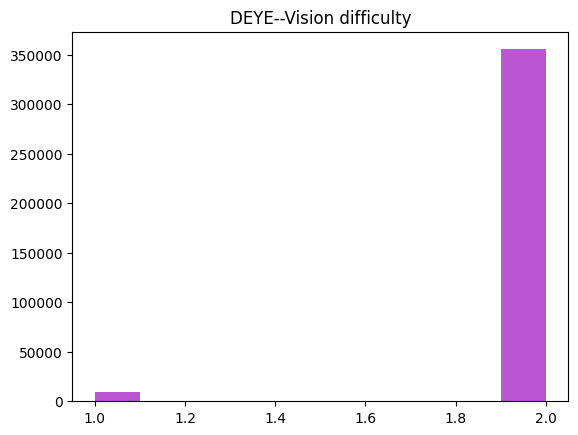

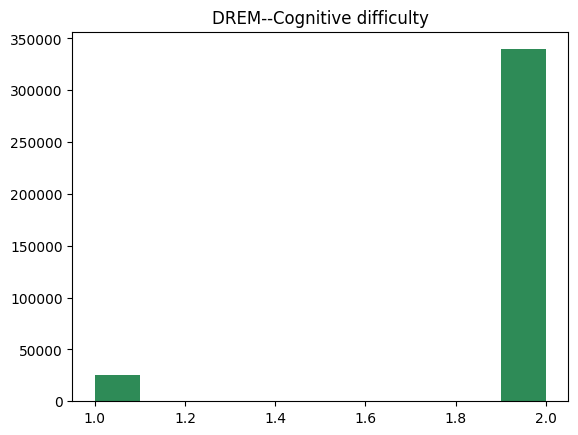

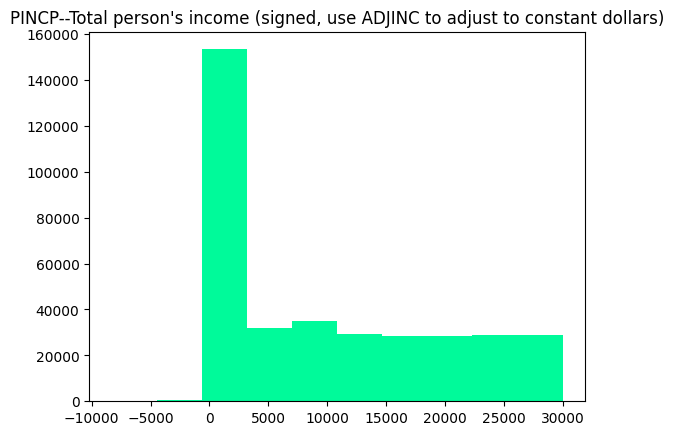

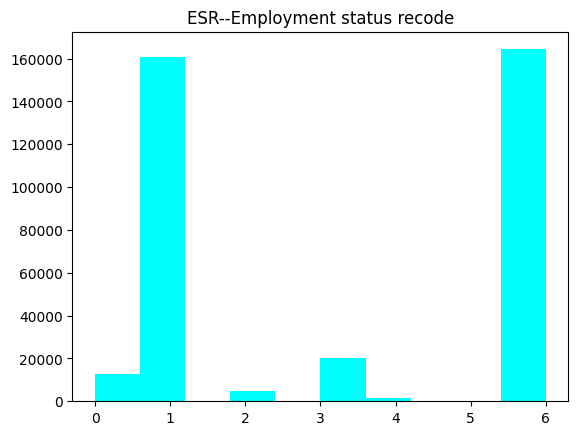

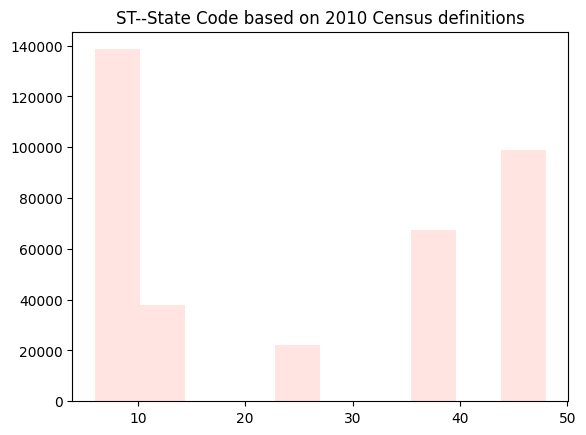

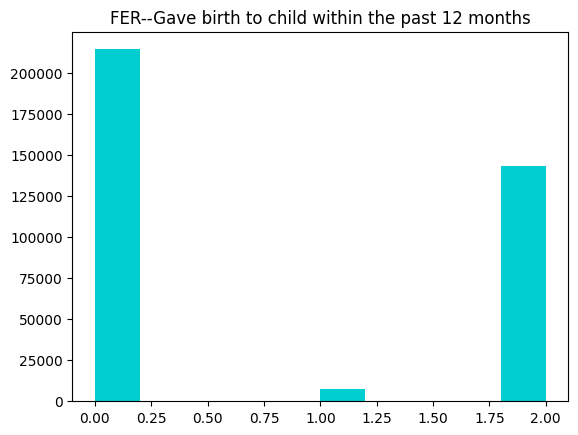

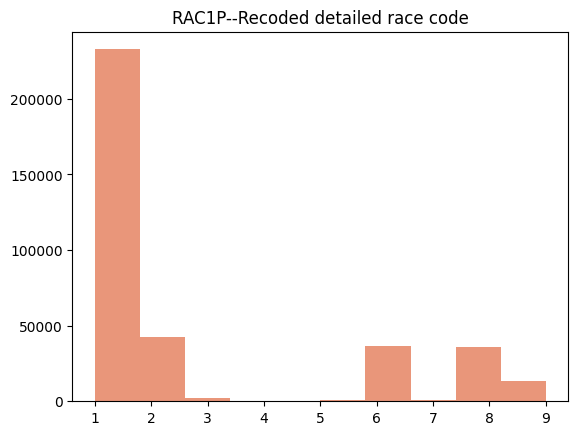

In [87]:
i = 0
used = {}
for col in features.columns:
    plt.hist(features[col],color=colors[i])
    plt.title(col+"--"+str(column_details[col]['Definition']))
    plt.show()
    used[col]=colors[i]
    i+=1
plt.show()